## Stacking [Explaination]

In [ ]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from os import makedirs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from numpy import dstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

### **Generate Data**

In [ ]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

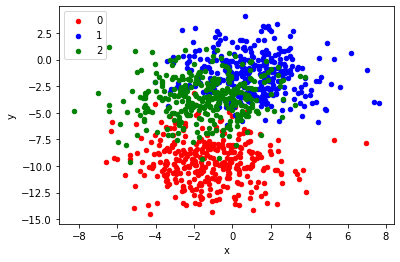

In [ ]:
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

Before we define a model, we need to contrive a problem that is appropriate for the stacking ensemble.

In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model.

We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multi-class classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, we must one hot encode the class values before we split the rows into the train and test datasets. We can do this using the Keras to_categorical() function.



### ***Combine all Together (1)***

In [ ]:
# develop an mlp for blobs dataset

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

(100, 2) (1000, 2)


KeyboardInterrupt: ignored

### **Train and Save Sub-Models**

To keep this example simple, we will use multiple instances of the same model as level-0 or sub-models in the stacking ensemble.

We will also use a holdout validation dataset to train the level-1 or meta-learner in the ensemble.

A more advanced example may use different types of MLP models (deeper, wider, etc.) as sub-models and train the meta-learner using k-fold cross-validation.

In this section, we will train multiple sub-models and save them to file for later use in our stacking ensembles.

**The first step is to create a function that will define and fit an MLP model on the training dataset.**

In [ ]:
# fit model on dataset
def fit_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=500, verbose=0)
	return model

Next, we can create a sub-directory to store the models.



In [ ]:
makedirs('models',exist_ok=True)

In this case, we will create five sub-models, but you can experiment with a different number of models and see how it impacts model performance.



In [ ]:
# fit and save models
n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(trainX, trainy)
	# save model
	filename = 'models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


### **Separate Stacking Model [Explaination don't run code]**

We can now train a meta-learner that will best combine the predictions from the sub-models and ideally perform better than any single sub-model.

The first step is to load the saved models.

We can use the load_model() Keras function and create a Python list of loaded models

In [ ]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

We can call this function to load our five saved models from the “models/” sub-directory.



In [ ]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models


It would be useful to know how well the single models perform on the test dataset as we would expect a stacking model to perform better.

We can easily evaluate each single model on the training dataset and establish a baseline of performance

In [ ]:
testy_enc.shape

(1000, 3, 2)

In [ ]:
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)

ValueError: ignored

**meta learner**

Next, we can train our meta-learner. This requires two steps:

Prepare a training dataset for the meta-learner.

Use the prepared training dataset to fit a meta-learner model

We will prepare a training dataset for the meta-learner by providing examples from the test set to each of the submodels and collecting the predictions. In this case, each model will output three predictions for each example for the probabilities that a given example belongs to each of the three classes. Therefore, the 1,000 examples in the test set will result in five arrays with the shape [1000, 3].

We can combine these arrays into a three-dimensional array with the shape [1000, 5, 3] by using the dstack() NumPy function that will stack each new set of predictions.

As input for a new model, we will require 1,000 examples with some number of features. Given that we have five models and each model makes three predictions per example, then we would have 15 (3 x 5) features for each example provided to the submodels. We can transform the [1000, 5, 3] shaped predictions from the sub-models into a [1000, 15] shaped array to be used to train a meta-learner using the reshape() NumPy function and flattening the final two dimensions. The stacked_dataset() function implements this step

In [ ]:
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

Once prepared, we can use this input dataset along with the output, or y part, of the test set to train a new meta-learner.



Once prepared, we can use this input dataset along with the output, or y part, of the test set to train a new meta-learner.

In this case, we will train a simple logistic regression algorithm from the scikit-learn library.

Logistic regression only supports binary classification, although the implementation of logistic regression in scikit-learn in the LogisticRegression class supports multi-class classification (more than two classes) using a one-vs-rest scheme. The function fit_stacked_model() below will prepare the training dataset for the meta-learner by calling the stacked_dataset() function, then fit a logistic regression model that is then returned.

In [ ]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model


In [ ]:
model = fit_stacked_model(members, testX, testy)

Once fit, we can use the stacked model, including the members and the meta-learner, to make predictions on new data.

This can be achieved by first using the sub-models to make an input dataset for the meta-learner, e.g. by calling the stacked_dataset() function, then making a prediction with the meta-learner. The stacked_prediction() function below implements this.

In [ ]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [ ]:
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

ValueError: ignored

### ***Combine all Together***

In [ ]:

# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

(100, 2) (1000, 2)
>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models
Model Accuracy: 0.807
Model Accuracy: 0.817
Model Accuracy: 0.815
Model Accuracy: 0.804
Model Accuracy: 0.811
Stacked Test Accuracy: 0.833


### **After Trained individual Models**

In [ ]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	#plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy_enc, epochs=300, verbose=0)
 
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, testX, testy)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

(100, 2) (1000, 2)
>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models
Stacked Test Accuracy: 0.831


# ***Stacking [Practical]***

## **Import Libs**

In [ ]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from os import makedirs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from numpy import dstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
import matplotlib.pyplot as plt

## **Data Preperation**

prepare data to X , y 

In [ ]:
# develop an mlp for blobs dataset

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


## **Build and Fit Base Models Then Save**

In [ ]:
# To Save Trained Models
makedirs('models',exist_ok=True)

**Model Arch Function**

In [ ]:
# fit model on dataset
histroies_indviduals = []
epochs_indviduals = []
def fit_model(trainX, trainy , epoch):
  # define model
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit model
  histroies_indviduals.append(model.fit(trainX, trainy, epochs=epoch, verbose=0))
  epochs_indviduals.append(epoch)
  return model

### **Fit n_members Models and Save**

In [ ]:
# fit and save models
n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(trainX, trainy , 500)
	# save model
	filename = 'models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


In [ ]:
histroies_indviduals[0].history.keys()

dict_keys(['loss', 'accuracy'])

### Indvidual Models Analysis

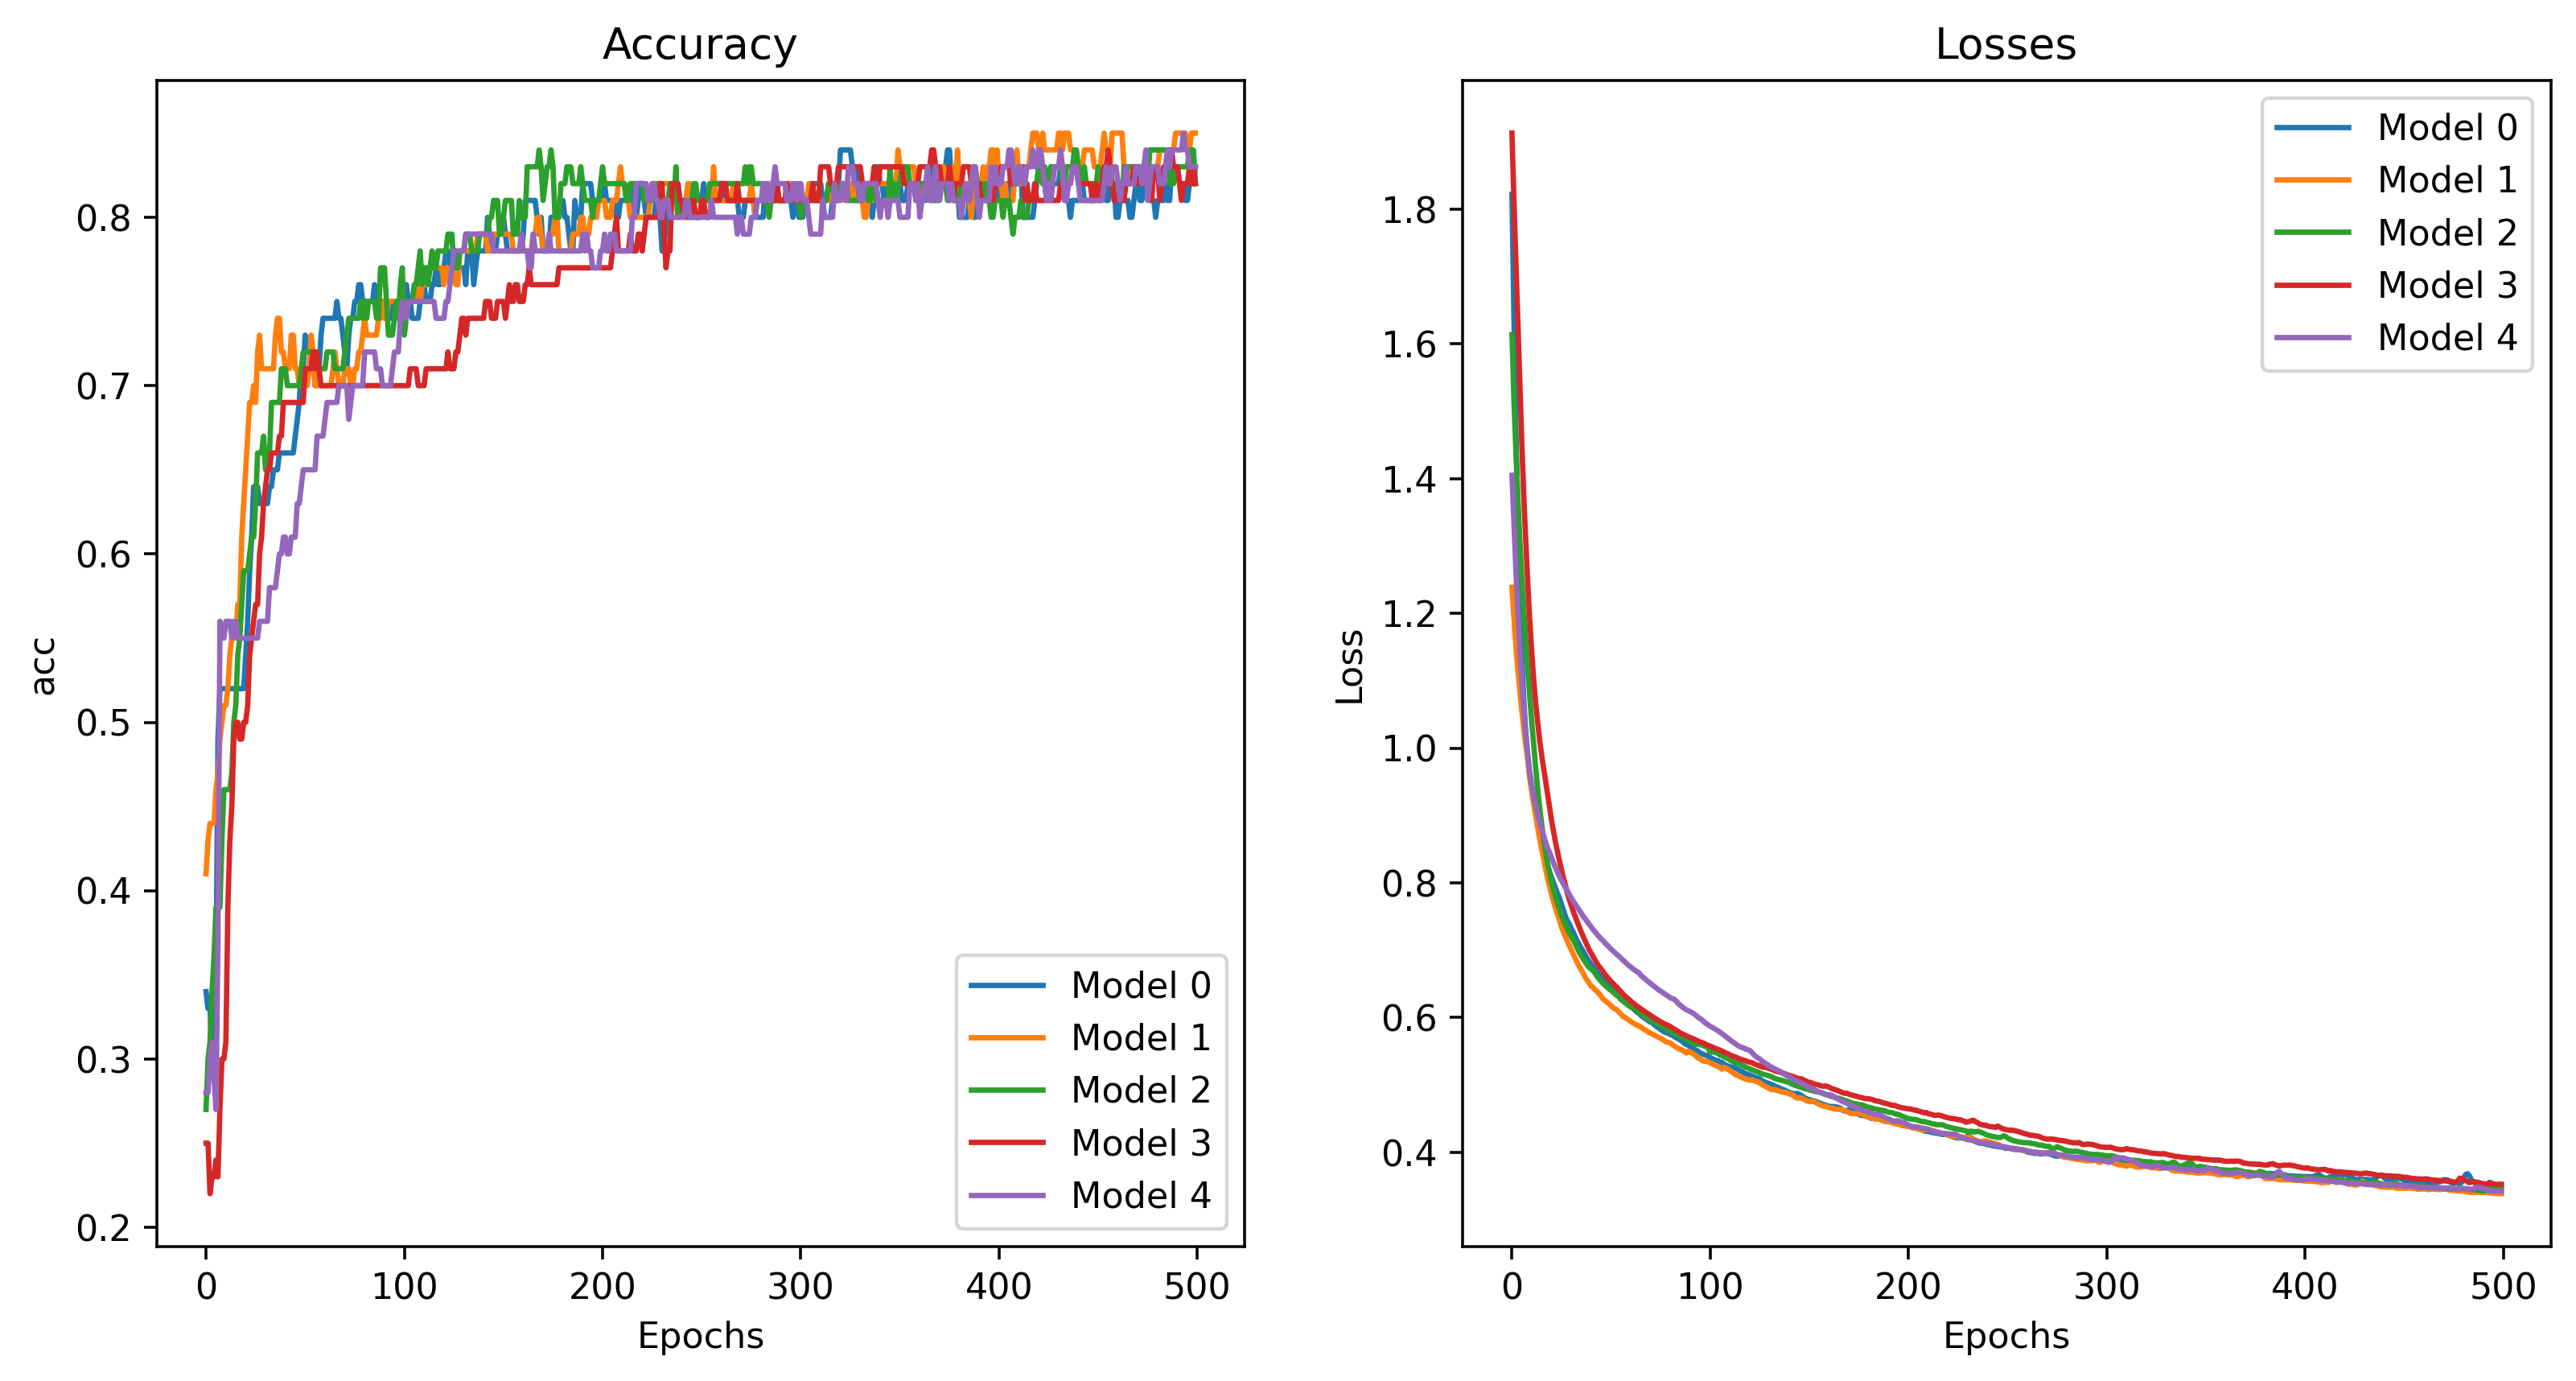

In [ ]:
fig,axes = plt.subplots(1,2 , figsize=(12,6) , dpi =320)
# Plot Accuracy for All Models
for i in range(n_members):
  x_axis = list(range(epochs_indviduals[i]))
  acc = histroies_indviduals[i].history['accuracy']
  axes[0].plot(x_axis,acc,label = f'Model {i}')
  axes[0].set_title('Accuracy')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('acc')
  axes[0].legend()

for i in range(n_members):
  x_axis = list(range(epochs_indviduals[i]))
  loss = histroies_indviduals[i].history['loss']
  axes[1].plot(x_axis,loss,label = f'Model {i}')
  axes[1].set_title('Losses')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Loss')
  axes[1].legend()


## ***Ensembling***

### **Load Trained Models Function**

In [ ]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 

### **Build Stacked Model and predict Function**

In [ ]:
stacked_epochs = 300
# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	#plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
  # prepare input data
  X = [inputX for _ in range(len(model.input))]
  # encode output data
  inputy_enc = to_categorical(inputy)
  # fit model
  histroy = model.fit(X, inputy_enc, epochs=stacked_epochs, verbose=0)
  return histroy  
 
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)

## **Run**

**Test Data must be new not seen before, so in this section i'll create new data**

In [ ]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [ ]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
histroy_stacked = fit_stacked_model(stacked_model, testX, testy)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.835


In [ ]:
histroy_stacked

## **Results Analysis**

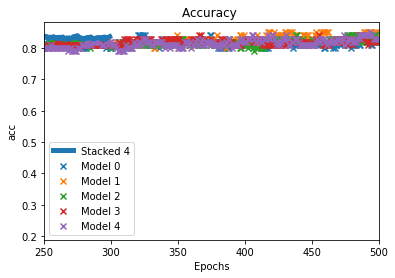

In [ ]:
fig = plt.figure()
for i in range(n_members):
  x_axis = list(range(epochs_indviduals[i]))
  acc = histroies_indviduals[i].history['accuracy']
  plt.scatter(x_axis,acc,label = f'Model {i}', linewidths = .1, marker='x')
  plt.title('Accuracy ')
  plt.xlabel('Epochs')
  plt.ylabel('acc')

x_axis = list(range(stacked_epochs))
acc = histroy_stacked.history['accuracy']
plt.plot(x_axis,acc,label = f'Stacked {i}' ,linewidth=5 )

plt.xlim([250,500])
plt.legend()

# **Bagging [Practical]**

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
from sklearn.model_selection import KFold
from sklearn.utils import resample

## **Random Splits [avg]**

The instability of the model and the small test dataset mean that we don’t really know how well this model will perform on new data in general.

We can try a simple resampling method of repeatedly generating new random splits of the dataset in train and test sets and fit new models. Calculating the average of the performance of the model across each split will give a better estimate of the model’s generalization error.

We can then combine multiple models trained on the random splits with the expectation that performance of the ensemble is likely to be more stable and better than the average single model.

We will generate 10 times more sample points from the problem domain and hold them back as an unseen dataset. The evaluation of a model on this much larger dataset will be used as a proxy or a much more accurate estimate of the generalization error of a model for this problem.

This extra dataset is not a test dataset. Technically, it is for the purposes of this demonstration, but we are pretending that this data is unavailable at model training time.

### **Data Preperation**

In [ ]:
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]


### **Build and Fit Base Models Then Save**

In [ ]:
# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
	# encode targets
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	# define model
	model = Sequential()
	model.add(Dense(50, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=50, verbose=0)
	# evaluate the model
	_, test_acc = model.evaluate(testX, testy_enc, verbose=0)
	return model, test_acc

#### **Training**

In [ ]:
# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	# split data
	trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.10)
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

>0.802
>0.806
>0.838
>0.824
>0.806
>0.840
>0.854
>0.818
>0.856
>0.818
Estimated Accuracy 0.826 (0.019)


#### **Evaluation** 

In [ ]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

In [ ]:
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.820, ensemble=0.820
> 2: single=0.821, ensemble=0.821
> 3: single=0.820, ensemble=0.821
> 4: single=0.820, ensemble=0.821
> 5: single=0.819, ensemble=0.821
> 6: single=0.821, ensemble=0.821
> 7: single=0.820, ensemble=0.821
> 8: single=0.818, ensemble=0.821
> 9: single=0.821, ensemble=0.821
> 10: single=0.820, ensemble=0.821
Accuracy 0.820 (0.001)


### **Analysis**

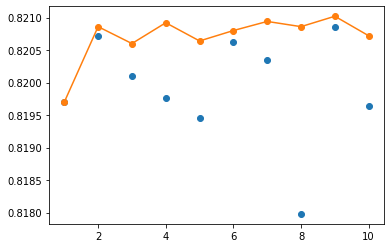

In [ ]:
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## **k-fold Cross-Validation**

A problem with repeated random splits as a resampling method for estimating the average performance of model is that it is optimistic.

### **Data Preperation**

In [ ]:
# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

### **Build and Fit Base Models Then Save**

#### **Training**

In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
	# encode targets
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	# define model
	model = Sequential()
	model.add(Dense(50, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=50, verbose=0)
	# evaluate the model
	_, test_acc = model.evaluate(testX, testy_enc, verbose=0)
	return model, test_acc


# prepare the k-fold cross-validation configuration
n_folds = 10
kfold = KFold(n_folds, True, 1)
# cross validation estimation of performance
scores, members = list(), list()
for train_ix, test_ix in kfold.split(X):
	# select samples
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

>0.842
>0.868
>0.822
>0.816
>0.814
>0.814
>0.810
>0.840
>0.820
>0.814
Estimated Accuracy 0.826 (0.017)


#### **Evaluation** 

In [ ]:

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 

 # evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_folds+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.821, ensemble=0.821
> 2: single=0.820, ensemble=0.821
> 3: single=0.819, ensemble=0.820
> 4: single=0.821, ensemble=0.820
> 5: single=0.816, ensemble=0.820
> 6: single=0.820, ensemble=0.820
> 7: single=0.819, ensemble=0.821
> 8: single=0.820, ensemble=0.821
> 9: single=0.820, ensemble=0.820
> 10: single=0.820, ensemble=0.820
Accuracy 0.820 (0.001)


### **Analysis**

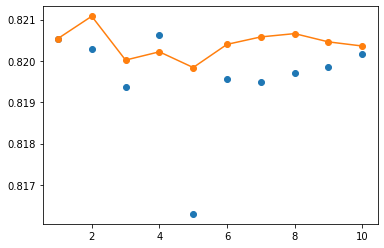

In [ ]:
x_axis = [i for i in range(1, n_folds+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## **Bootstrap Aggregation**

### **Data Preperation**

In [ ]:
# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

### **Build and Fit Base Models Then Save**

In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
	# encode targets
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	# define model
	model = Sequential()
	model.add(Dense(50, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=50, verbose=0)
	# evaluate the model
	_, test_acc = model.evaluate(testX, testy_enc, verbose=0)
	return model, test_acc

  # multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	# select indexes
	ix = [i for i in range(len(X))]
	train_ix = resample(ix, replace=True, n_samples=4500)
	test_ix = [x for x in ix if x not in train_ix]
	# select data
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)

>0.820
>0.833
>0.817
>0.841
>0.822
>0.831
>0.827
>0.819
>0.826
>0.830


#### **Evaluation** 

In [ ]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 

In [ ]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.820, ensemble=0.820
> 2: single=0.821, ensemble=0.821
> 3: single=0.819, ensemble=0.820
> 4: single=0.821, ensemble=0.820
> 5: single=0.819, ensemble=0.821
> 6: single=0.821, ensemble=0.820
> 7: single=0.820, ensemble=0.821
> 8: single=0.818, ensemble=0.820
> 9: single=0.820, ensemble=0.820
> 10: single=0.819, ensemble=0.820
Accuracy 0.820 (0.001)


### **Analysis**

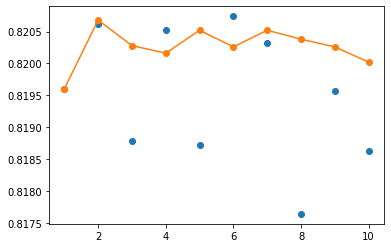

In [ ]:
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()